In [ ]:
!pip install evaluate
!pip install seqeval
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.1 MB/s 
     |████████████████████████████████| 115 kB 9.0 MB/s 
     |████████████████████████████████| 212 kB 55.4 MB/s 
     |████████████████████████████████| 101 kB 12.3 MB/s 
     |████████████████████████████████| 365 kB 65.4 MB/s 
     |████████████████████████████████| 141 kB 33.9 MB/s 
     |████████████████████████████████| 596 kB 70.4 MB/s 
     |████████████████████████████████| 127 kB 75.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |███████████████████████████

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import evaluate 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datasets
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import DataCollatorForTokenClassification
from datasets import load_dataset
from transformers import AutoModelForTokenClassification
from transformers import TrainingArguments
from transformers import Trainer
from transformers import pipeline
from seqeval.metrics import classification_report
from transformers import AutoModelForSequenceClassification

In [ ]:
cd /content/drive/MyDrive/SentimentAnalysis

In [ ]:
df = pd.read_csv('Data/im_data.csv')

In [ ]:
df2 = pd.concat([df.drop(['label'], axis=1), df['label'].str.get_dummies()], axis=1)
df2.head()

,text,Negatif Yorum,Pozitif Yorum
0,Kaşıkla toplayanlar kepçe ile verecek 😒,1,0
1,çok ucuzlamış olacak,1,0
2,"5,22 TL'yi test ihtimali yüksek bulunuyor",0,1
3,#akbnk ve #ykbnk lçin güzel bir gün olacak yine,0,1
4,üzeri ayılar düşünsün,0,1


In [ ]:
df2.drop(['Negatif Yorum'], axis=1, inplace=True)
df2.rename(columns={'Pozitif Yorum': 'label'}, inplace=True)
# 1 for Pozitif 0 for Negatif
df2.head()

,text,label
0,Kaşıkla toplayanlar kepçe ile verecek 😒,0
1,çok ucuzlamış olacak,0
2,"5,22 TL'yi test ihtimali yüksek bulunuyor",1
3,#akbnk ve #ykbnk lçin güzel bir gün olacak yine,1
4,üzeri ayılar düşünsün,1


# Model and Tokenizer

In [ ]:
model_path = "dbmdz/bert-base-turkish-128k-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_path, max_len=512)

# Train - Test - Split 

In [ ]:
train, test = train_test_split(df2, test_size=0.1, random_state=42)
train, val = train_test_split(train, test_size=0.11, random_state=42)
len(train), len(val), len(test)

(209, 26, 27)

In [ ]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
train_dataset = datasets.Dataset.from_pandas(train)
test_dataset = datasets.Dataset.from_pandas(test)
val_dataset = datasets.Dataset.from_pandas(val)

In [ ]:
train_dataset[0]

{'label': 0, 'text': 'bunun altında kapanışlarda satışlar dahada derinleşir.'}

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [ ]:
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)
tokenized_val = val_dataset.map(preprocess_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
tokenized_train

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 209
})

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
label2id = {'Negatif Yorum':0, 'Pozitif Yorum':1}
id2label = {v:k for k,v in label2id.items()}

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_path, id2label=id2label,label2id=label2id)

loading configuration file https://huggingface.co/dbmdz/bert-base-turkish-128k-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/120e27321f5f101e4616b430bb300523eb0c464006badb271fc4a80ecb3f4551.453a629e781b4c858049daeb69936fc02d2ee7e3314c6c65fa5f432c13470419
Model config BertConfig {
  "_name_or_path": "dbmdz/bert-base-turkish-128k-uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Negatif Yorum",
    "1": "Pozitif Yorum"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Negatif Yorum": 0,
    "Pozitif Yorum": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.1",
  "type_vocab_size": 2,
  "use_cache": 

In [ ]:
metric = evaluate.load("seqeval")

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted") 
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [ ]:
args = TrainingArguments(
    "bert-finetuned-sa-bist30",
    evaluation_strategy="steps",
    eval_steps=10,
    save_strategy="steps",
    save_steps=10,
    logging_steps=10,
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end = True,
    report_to="tensorboard",
    metric_for_best_model="accuracy"
)

PyTorch: setting up devices


In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics= compute_metrics
)

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 209
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss,Validation Loss,Accuracy,F1
10,0.728400,0.715525,0.444444,0.416394
20,0.736900,0.685411,0.518519,0.472663
30,0.725200,0.689686,0.444444,0.424394
40,0.719700,0.781644,0.481481,0.464198
50,0.628300,0.717849,0.555556,0.551893


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 27
  Batch size = 16
Saving model checkpoint to bert-finetuned-sa-bist30/checkpoint-10
Configuration saved in bert-finetuned-sa-bist30/checkpoint-10/config.json
Model weights saved in bert-finetuned-sa-bist30/checkpoint-10/pytorch_model.bin
tokenizer config file saved in bert-finetuned-sa-bist30/checkpoint-10/tokenizer_config.json
Special tokens file saved in bert-finetuned-sa-bist30/checkpoint-10/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Runni

TrainOutput(global_step=56, training_loss=0.7030092052050999, metrics={'train_runtime': 67.6491, 'train_samples_per_second': 12.358, 'train_steps_per_second': 0.828, 'total_flos': 9184220276160.0, 'train_loss': 0.7030092052050999, 'epoch': 4.0})

In [ ]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 16


{'epoch': 4.0,
 'eval_accuracy': 0.8780487804878049,
 'eval_f1': 0.8722745750184777,
 'eval_loss': 0.2787550091743469,
 'eval_runtime': 0.1534,
 'eval_samples_per_second': 534.61,
 'eval_steps_per_second': 39.118}

In [ ]:
preds_output = trainer.predict(tokenized_test)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 27
  Batch size = 16


In [ ]:
preds_output.metrics

{'test_accuracy': 0.5555555555555556,
 'test_f1': 0.5518925518925519,
 'test_loss': 0.7178488373756409,
 'test_runtime': 0.055,
 'test_samples_per_second': 491.098,
 'test_steps_per_second': 36.378}

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) 
  plt.title("Normalized confusion matrix")
  plt.show()

In [ ]:
label_names = ['Pozitif Yorum', 'Negatif Yorum']

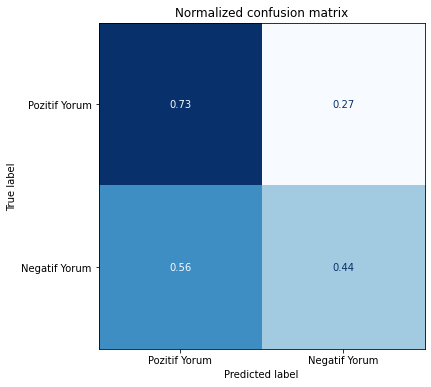

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, tokenized_test['label'], label_names)

In [ ]:
model.save_pretrained("model/bert-finetuned-sa-bist30")
tokenizer.save_pretrained("model/tokenizer")

Configuration saved in model/bert-finetuned-sa-bist30/config.json
Model weights saved in model/bert-finetuned-sa-bist30/pytorch_model.bin
tokenizer config file saved in model/tokenizer/tokenizer_config.json
Special tokens file saved in model/tokenizer/special_tokens_map.json


('model/tokenizer/tokenizer_config.json',
 'model/tokenizer/special_tokens_map.json',
 'model/tokenizer/vocab.txt',
 'model/tokenizer/added_tokens.json',
 'model/tokenizer/tokenizer.json')

In [ ]:
sentiment = pipeline("text-classification", model="model/bert-finetuned-sa-bist30", tokenizer="model/tokenizer")

loading configuration file model/bert-finetuned-sa-bist30/config.json
Model config BertConfig {
  "_name_or_path": "model/bert-finetuned-sa-bist30",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Negatif Yorum",
    "1": "Pozitif Yorum"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Negatif Yorum": 0,
    "Pozitif Yorum": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.21.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 128000
}

loading configuration file model/bert-finetuned-sa-bist30/c

In [ ]:
ex = "sene sonunda mükemmel patlayacak "
sentiment(ex)

[{'label': 'Pozitif Yorum', 'score': 0.6130897402763367}]